In [1]:
from pathlib import Path
import sqlalchemy
import sys
import os
module_path = Path("../src/")
os.chdir(module_path)
sys.path.append(module_path)
from collections import defaultdict, OrderedDict
import warnings
warnings.filterwarnings('ignore')

In [2]:
from decision_tree.structure import *
from decision_tree.functions import *
from data_processing.functions import *
from data_processing.features import *
from data_access.load_file import *
from vizualizations import *

Initialize Tree first

In [3]:
tree = Tree()

Initialize all nodes

In [4]:
node_labels = ["Analyze", "Design", "Build", "Test", "Package", "Accept", "Deploy", "End"]

In [5]:
def _init_nodes(node_labels: list = None):
    nodes = OrderedDict()
    for label in node_labels:
        nodes[label] = Node({"label": label, "time": 0})
    return nodes

In [6]:
nodes = _init_nodes(node_labels)

Add all nodes to the tree

In [7]:
for node in nodes.values():
    tree.add_node(node)

Initialize all edges

In [8]:
def _init_edges(node_labels, nodes):
    edges = []
    for i in range(len(node_labels)-1):
        from_node = nodes[node_labels[i]]
        to_node = nodes[node_labels[i+1]]
        edge1 = Edge(data={"weight": 0}, from_node=from_node, to_node=to_node)
        edges.append(edge1)
        if node_labels[len(node_labels)-1] not in edge1.prints():
            end_node = nodes[node_labels[len(node_labels)-1]]
            edge2 = Edge(data={"weight": 0}, from_node=from_node, to_node=end_node)
            edges.append(edge2)
    return edges

In [9]:
edges = _init_edges(node_labels, nodes)

Add all edges to the tree

In [10]:
for edge in edges:
    tree.add_edge(edge)

Print tree to see if this was succesful

In [11]:
process2 = [(str(x.prints()[0]).replace(":","="), str(x.prints()[1]).replace(":","=")) for x in tree.edges]

In [12]:
g = plot_process(process=process2, name="Init_Tree", path="../plots/")

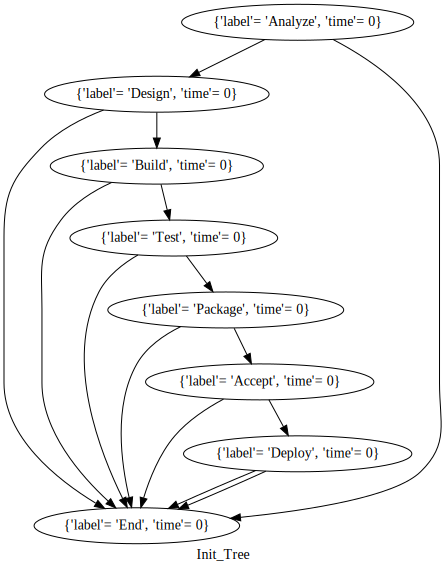

In [13]:
g

Looks good. Tree should get a function .plot() for easier plotting. Edges should have their weights as labels

Nice! Let's structure that and put it into functions. We now want to fill the tree with real data from our dataset

In [14]:
filename = Path("../data/gdsc2_public.csv")
data = load_table(filename)
times = time_for_phase(data, end_date=None)
work_time = work_times(times, time_col="duration_in_days")
work_freq = work_times(times)

In [16]:
merged = pd.merge(work_time, work_freq)
merged.set_index("work_item", inplace=True)

In [17]:
wi1 = merged.loc["WI_000165"].to_dict()

Initialize Tree with all nodes

In [18]:
tree = Tree()
tree, nodes = init_nodes(tree, data=wi1)

Initialize edges

In [19]:
data = add_phase(data, col_name="phase", cols=["from_phase", "to_phase"])
phases = data.groupby("work_item")["phase"].unique().to_dict()
wi1 = phases["WI_000165"]

In [20]:
tree, edges = init_edges(tree, nodes, path=wi1)

In [21]:
g = tree.plot(name="Init_Tree", path="../plots/")

Looks good. Now we are able to convert every work item into a tree object. We should write a function for this.

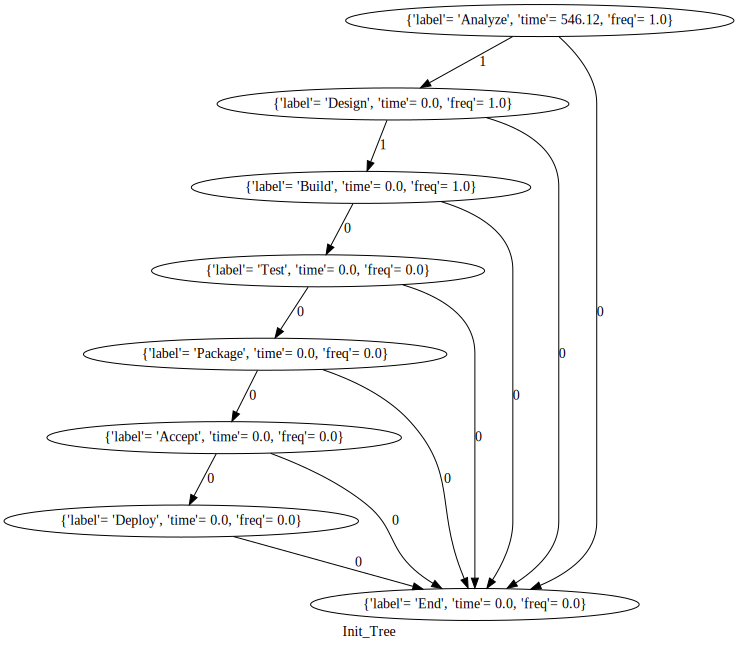

In [23]:
tree2 = get_tree(data, merged, "WI_000165")
tree2.plot(name="Init_Tree", path="../plots/")

Great! Now we should think about the algorithmn. It would be perfect if we choose an algorithmn that predicts probabilities as weights for the edges. We could than try to fit this into a linear model as new features.